<h3 align="center"><font size="6.5">Projet 8 : Déployez un modèle dans le cloud</font></h3>

<h3 align="center"><font size="5">Création des vecteurs (local)</font></h3>

* [Chapitre 1 : Préparation des données](#chapter1)
    * [Librairies et données](#section_1_1)
    * [Session Spark](#section_1_2)
    * [Dataframe](#section_1_3)
       
* [Chapitre 2 : Modélisation](#chapter2)
    * [Création de fonction](#section_2_1)
    * [Réduction dimensionnelle](#section_2_2)
    * [Sauvegarde des données](#section_2_3)

<a class="anchor" id="chapter1"></a>
# Chapitre 1 : Préparation des données
Nous allons travailler sur la reconnaissance d'images de fruits et légumes (localement). Nous avons sélectionné un jeu de données réduits qui est composé de 5 fruits et légumes.

<a class="anchor" id="section_1_1"></a>
## Librairies et données

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.sql import SparkSession

2023-06-18 11:45:19.967501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dans le cadre du traitement des données, nous allons utiliser deux répertoires :
- un répertoire pour les données d'entrée qui contient 373 images et 
- un répertoire pour récupérer les données traitées en sortie.

In [2]:
PATH = os.getcwd()

PATH_Data = PATH+'/test_local'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /home/faridkameche/Projet_8/jup_notebook/P8
PATH_Data:   /home/faridkameche/Projet_8/jup_notebook/P8/test_local
PATH_Result: /home/faridkameche/Projet_8/jup_notebook/P8/Results


<a class="anchor" id="section_1_2"></a>
## Session Spark

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**.
<u>Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur
dans l’ensemble du cluster</u>. <u>Une SparkSession correspond toujours à une application Spark</u>.

<u>Ici nous créons une session spark en spécifiant dans l'ordre</u> :
- un **nom pour l'application**, qui sera affiché dans l'interface utilisateur Web Spark (**P8**),
- une execution en **local** de l'application (nous ne définissons pas le nombre de cœurs à utiliser mais nous pourrions le faire avec .master('local[X]) pour X cœurs à utiliser),
- une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** que nous utiliserons pour enregistrer et charger le résultat de notre travail et
- vouloir **obtenir une session spark** existante ou si aucune n'existe, en créer une nouvelle.

In [3]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

23/06/18 11:45:23 WARN Utils: Your hostname, Ubuntu resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/06/18 11:45:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/18 11:45:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Nous crééons un objet de type sparkContext permettant la gestion globale de l'application (niveau de logging, niveau de parallélisation...) et nous affichons ensuite les informations de cet objet.

In [4]:
sc = spark.sparkContext

spark

<a class="anchor" id="section_1_3"></a>
## Dataframe
Nous allons charger les données dans un dataframe pandas UDF dans un format binaire pour offrir plus de souplesse dans le prétraitement des images. Nous ajoutons comme option qu'il faut charger l'ensemble eds images au format jpg et que nous chargeons toutes les données des sous dossiers du dossier ciblé.

In [5]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [6]:
images

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary]

In [7]:
print(images.printSchema())
print(images.select('path').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

None


+-------------------------------------------------------------------------------------------+
|path                                                                                       |
+-------------------------------------------------------------------------------------------+
|file:/home/faridkameche/Projet_8/jup_notebook/P8/test_local/Apple Crimson Snow/r_25_100.jpg|
|file:/home/faridkameche/Projet_8/jup_notebook/P8/test_local/Apple Crimson Snow/r_24_100.jpg|
|file:/home/faridkameche/Projet_8/jup_notebook/P8/test_local/Apple Crimson Snow/r_30_100.jpg|
|file:/home/faridkameche/Projet_8/jup_notebook/P8/test_local/Apple Crimson Snow/r_32_100.jpg|
|file:/home/faridkameche/Projet_8/jup_notebook/P8/test_local/Apple Crimson Snow/r_26_100.jpg|
+-------------------------------------------------------------------------------------------+
only showing top 5 rows

None


Nous voyons bien que les chemins vers les différentes images ont bien été chargés. Nous allons créer une colonne pour associer chaque fichier au label auquel il est associé.

In [8]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+-------------------------------------------------------------------------------------------+------------------+
|path                                                                                       |label             |
+-------------------------------------------------------------------------------------------+------------------+
|file:/home/faridkameche/Projet_8/jup_notebook/P8/test_local/Apple Crimson Snow/r_25_100.jpg|Apple Crimson Snow|
|file:/home/faridkameche/Projet_8/jup_notebook/P8/test_local/Apple Crimson Snow/r_24_100.jpg|Apple Crimson Snow|
|file:/home/faridkameche/Projet_8/jup_notebook/P8/test_local/Apple Crimson Snow/r_30_100.jpg|Apple Crimson Snow|
|file:/home/faridkameche/Projet_8/jup_notebook/P8/test_local/Apple Crimson Snow/r_32_100.jpg|Apple Crimson Snow|

<a class="anchor" id="chapter2"></a>
# Chapitre 2 : Modélisation
<a class="anchor" id="section_2_1"></a>
## Création de fonctions

Nous allons utiliser le modèle MobileNetV2 qui est un modèle conçu pour classifier des images selon 1000 classes. Ce modèle présente l'avantage d'être plus rapide à éxecuter que le modèle VGG16. Comme nous ne voulons pas de la classification (dernière couche), nous créeons un modèle qui va exclure la dernière couche (Transfer learning).

En revanche, nous spécifions que les données d'entrées doivent avoir une dimension de 224x224x3, ce qui est la dimension par défaut pour le modèle MobileNetV2. Nous serons donc amené à redimensionner les images que nous allons utiliser.

In [9]:
model_initial = MobileNetV2(weights='imagenet',
                            include_top=True,
                            input_shape=(224, 224, 3))

model_transfer_learning = Model(inputs=model_initial.input,
                                outputs=model_initial.layers[-2].output)

model_transfer_learning.summary()

2023-06-18 11:45:33.413118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 11:45:33.433724: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

Afin que tous les workers (ordinateurs/serveurs) puissent accéder au modèle ainsi qu'à ses poids, nous chargeons le modèle sur le driver puis les poids sont diffusés aux différents workeurs.

In [10]:
broadcast_weights = sc.broadcast(model_transfer_learning.get_weights())

In [11]:
broadcast_weights

In [12]:
print(len(model_transfer_learning.get_weights()))

260


Nous allons créer des fonctions permettant de :
- retourner le modèle dont la diffusion des poids du modèle est traitée,
- prétraiter les images (changement de dimension puis transformation en array) et
- retourner un pd.Series de chaque données d'entrée dont la dimension sera (1,1,1280).

Enfin, nous créeons une application Spark (@pandas_udf) qui combinera l'ensemble des fonctions précédentes.

In [13]:
def model_fn():
    """
    Retourne un modèle MobileNetV2 où la dernière couche a été retirée
    et avec une diffusion des poids du modèle pré-entraîné.
    """
    model = MobileNetV2(weights=None,
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(broadcast_weights.value)
    return new_model

In [14]:
def pretraitement(content):
    """
    Prétraitement des images brut pour les mettre à la bonne dimension (224,224,3).
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

In [15]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(pretraitement))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [16]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches. This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/faridkameche/anaconda3/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Nous créeons un nouveau dataframe pandas udf basé sur le dataframe "images". Les deux premières colonnes représentent les deux colonnes du dataframe pandas udf "images" ("path" et "label"). La troisème colonne représente le résultat de l'application @pandas_udf (featurization).

In [17]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<a class="anchor" id="section_2_2"></a>
## Réduction dimensionnelle
En appliquant le modèle MobilenNetV2, les features comportent 1280 valeurs. Nous allons réduire ce nombre grâce a une ACP. Nous allons d'abord normaliser les données grâce à un RobustScaler puis effectuer une ACP.

Pour ce faire, nous devons convertir chaque feature, qui sont des arrays en vecteurs pour que la normalisation et l'ACP puisse se faire. Nous imposerons ensuite que le nombre de composantes principales soit de 1280 pour commencer.

In [18]:
from pyspark.ml.feature import PCA, StandardScaler, RobustScaler
from pyspark.ml.linalg import Vectors, VectorUDT

arr_to_vect = udf(lambda a:Vectors.dense(a), VectorUDT())
vect_features_df = features_df.withColumn("vecteur", arr_to_vect("features"))

scaler = RobustScaler(inputCol="vecteur", outputCol="scaled_features").fit(vect_features_df)
# scaler_std = StandardScaler(inputCol="vecteur", outputCol="scaled_features").fit(vect_features_df)

2023-06-18 11:45:40.864540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 11:45:42.280962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 11:45:42.282419: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
1/1 [==============================] - 1s 769ms/step
2023-06-18 11:45:45.753944: I tensorflow/core/plat

In [19]:
df_std = scaler.transform(vect_features_df)
# df_std = scaler_std.transform(vect_features_df)

In [20]:
n_components=1280

pca = PCA(k=n_components, inputCol="scaled_features", outputCol="pca_features").fit(df_std)

1/1 [==============================] - 2s 2s/step                  (0 + 1) / 20]
23/06/18 11:48:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
1/1 [==============================] - 2s 2s/step==============>  (19 + 1) / 20]
23/06/18 11:49:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [21]:
data_pca = pca.transform(df_std)

Nous traçons l'éboulis des valeurs propres pour déterminer combien de composantes princiaples expliquent 90 % des données.

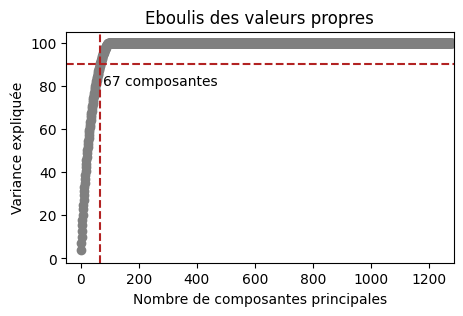

In [22]:
import matplotlib.pyplot as plt

exp_var = pca.explainedVariance.cumsum()
n_comp = len(exp_var) - len(exp_var[exp_var>0.9])

plt.figure(figsize=(5,3))

plt.scatter(x = np.arange(1,1281),y=exp_var*100, color="gray")

plt.axhline(y=90, color="firebrick", ls = "--") 
plt.axvline(x=n_comp, color="firebrick", ls = "--") 

plt.text(n_comp+10, 80, f"{n_comp} composantes")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée")

plt.xlim(-50,1285)
plt.ylim(-2,105)
plt.title("Eboulis des valeurs propres")

plt.show()

Nous voyons que nous pouvons expliquer 90 % des données avec 67 composantes principales. Nous allons recommencer l'ACP en choisissant 67 comme nouveau nombre de composantes principales.

In [23]:
pca = PCA(k=67, inputCol="vecteur", outputCol="pca_features").fit(vect_features_df)

data_pca = pca.transform(vect_features_df)

2023-06-18 14:00:20.721894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 14:00:24.790517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 14:00:24.798093: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
1/1 [==============================] - 2s 2s/step==============>  (19 + 1) / 20]


In [24]:
from pyspark.ml.functions import vector_to_array

data_to_keep = data_pca.select("path","label", vector_to_array("pca_features").alias("pca_features"))

In [25]:
data_to_keep.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- pca_features: array (nullable = false)
 |    |-- element: double (containsNull = false)



<a class="anchor" id="section_2_3"></a>
## Sauvegarde des données
Nous enregistrons les données au format "parquet" et nous allons réimporter les résultats pour les lire avec un pandas dataframe.

In [26]:
data_to_keep.write.mode("overwrite").parquet(PATH_Result)

1/1 [==============================] - 2s 2s/step==============>  (19 + 1) / 20]


In [27]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [28]:
df.head()

,path,label,pca_features
0,file:/home/faridkameche/Projet_8/jup_notebook/...,Apple Crimson Snow,"[0.6420341557911649, 0.2850588794354392, -0.14..."
1,file:/home/faridkameche/Projet_8/jup_notebook/...,Apple Crimson Snow,"[-0.33249183595741355, 0.18036149425484463, -0..."
2,file:/home/faridkameche/Projet_8/jup_notebook/...,Apple Braeburn,"[-6.503162075937587, 0.13062661092468053, 0.03..."
3,file:/home/faridkameche/Projet_8/jup_notebook/...,Apple Crimson Snow,"[-0.16060056517923887, 0.20621745038656755, -0..."
4,file:/home/faridkameche/Projet_8/jup_notebook/...,Apple Braeburn,"[-6.726867938159116, -0.19763441302674584, -0...."


In [29]:
df.loc[0,'pca_features'].shape

(67,)

In [30]:
df.shape

(373, 3)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   path          373 non-null    object
 1   label         373 non-null    object
 2   pca_features  373 non-null    object
dtypes: object(3)
memory usage: 8.9+ KB
